# Set Conda environment

In [1]:
# First, run this cell by itself, then run the cells above
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:07
🔁 Restarting kernel...


In [ ]:
# Then when the previuos cell execution is terminated run this
!conda create -n myenv python=3.7.5 -q
PYENV = "/usr/local/envs/myenv/bin"

# Set the path variables

In [2]:
import os

# Set the paths
DATASET_HOME_DIR = '/content/drive/MyDrive/DLProj/Dataset'
CHECKPOINTS_DIR = '/content/drive/MyDrive/DLProj/vqvae_openai/checkpoints'
WAV_DATASET_DIR = os.path.join(DATASET_HOME_DIR, "WavVersion/train_small_files")  # the Slackh2100 dataset with .wav stems
REPO_DIR = '/content/masked-lm-audio'
JUKEBOX_DIR = f'{REPO_DIR}/jukebox'

# Clone the repo
!git clone https://github.com/matpaolacci/masked-lm-audio.git --quiet

# Prepare the environment for the Jukebox VQ-VAE

In [3]:
!conda install -q -n myenv av=7.0.01 -c conda-forge
!$PYENV/pip install -e $JUKEBOX_DIR -q
!$PYENV/pip install $JUKEBOX_DIR/tensorboardX -q
!$PYENV/pip install torch==1.4.0 torchvision==0.5.0 protobuf==3.20.* -q

# Train Jukebox VQ-VAE

In [ ]:
!mpiexec --allow-run-as-root -n 1 $PYENV/python $JUKEBOX_DIR/jukebox/train.py \
--hps=vqvae \
--name=my_vqvae \
--bs=2 \
--epochs=450 \
--audio_files_dir=$WAV_DATASET_DIR \
--labels=False \
--train \
--test \
--downs_t="(3, 3, 2)" \
--bandwidth_duration=200 \
--restore_vqvae='' \
--checkpoint_dir=$CHECKPOINTS_DIR \
--sample_length=174_080 \
--stft_idx_increment=1 \
--aug_shift \
--aug_blend \
--debug_inputs

# Encode audio track with Jukebox VQ-VAE

In [ ]:
# Pull latest commits
!git -C $REPO_DIR pull origin main

In [ ]:
!mpiexec --allow-run-as-root -n 1 $PYENV/python $JUKEBOX_DIR/jukebox/inference.py \
--hps=vqvae \
--name=my_vqvae_test \
--bs=2 \
--use_level=2 \
--audio_files_dir=$WAV_DATASET_DIR \
--labels=False \
--operation_type="encode" \
--downs_t="(3, 2, 2)" \
--restore_vqvae='/content/drive/MyDrive/DLProj/vqvae_openai/2024-12-31T01:00/epoch_424_2.6035' \
--sample_length=174_080 \
--stft_idx_increment=1

# Decode audio track with Jukebox VQ-VAE

In [4]:
# if doesn't exist
os.makedirs("/content/logs/my_vqvae_test/encoded_data", exist_ok=True)

In [5]:
# only one file at time

!mpiexec --allow-run-as-root -n 1 $PYENV/python $JUKEBOX_DIR/jukebox/inference.py \
--hps=vqvae \
--name=my_vqvae_test \
--bs=2 \
--use_level=1 \
--path_to_encoded_data="/content/logs/my_vqvae_test/encoded_data/bert.output_2.json" \
--labels=False \
--operation_type="decode" \
--downs_t="(3, 3, 2)" \
--restore_vqvae='/content/drive/MyDrive/DLProj/vqvae_openai/2024-12-31T01:00/epoch_424_2.6035' \
--sample_length=174_080 \
--stft_idx_increment=1

Using cuda True
Restored from /content/drive/MyDrive/DLProj/vqvae_openai/2024-12-31T01:00/epoch_424_2.6035
0: Loading vqvae in eval mode
Logging to logs/my_vqvae_test
Do decoding...
Decoding embedding sequence at /content/logs/my_vqvae_test/encoded_data/bert.output_2.json
100%|██████████| 44/44 [00:20<00:00,  2.14it/s]Saving file...
File saved at logs/my_vqvae_test/decoded_data/bert.output_2.wav



# Quantitative Evaluation of the generated audio from BERT
In the following section I previously masked an audio sequence and fed it to bert. Here we decode this sequence to restore it to wav format.
In this example Jukebox VQ-VAE compresses the sequence by a factor of $64x$ that seems working "better" than $16x$. However BERT learnt again only the noise.

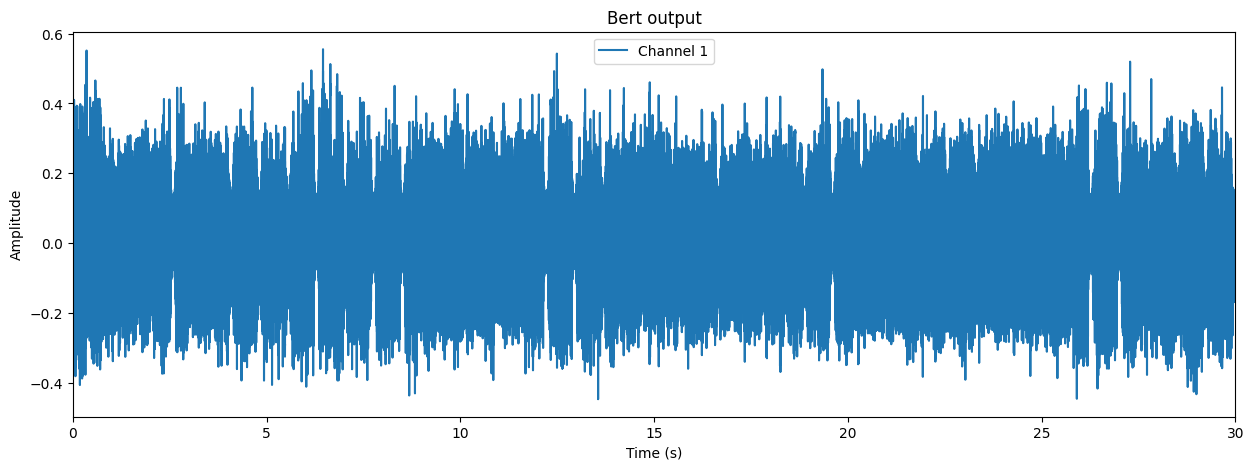

In [11]:
# @title
import matplotlib.pyplot as plt
import torch
import IPython.display as ipd
import numpy as np
from torchaudio import load

def plot_waveform(waveform, graph_title: str, from_sec:float = None, to_sec: float = None, sample_rate = 44100):

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    # Crea il plot
    plt.figure(figsize=(15, 5))

    for i in range(num_channels):
        plt.plot(time_axis.numpy(), waveform[i].numpy(), label=f'Channel {i+1}')

    # Imposta range di visualizzazione su asse x
    duration_in_sec = num_frames / sample_rate
    plt.xlim(from_sec if from_sec is not None else 0, to_sec if to_sec is not None else duration_in_sec)

    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(graph_title)
    plt.legend()
    plt.show()


bert_output = load("/content/logs/my_vqvae_test/decoded_data/bert.output_2.wav")[0][:,:44100*30] # first 30 seconds

bert_output_np = bert_output.cpu().numpy()
ipd.display(ipd.Audio(bert_output_np, rate=44100))
plot_waveform(bert_output, graph_title=f"Bert output")